In [ ]:
!pip install --upgrade matplotlib > None # need refresh enviroment after installation

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
!pip install basemap > None

In [133]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline

### **Подготовительный этап (взят с первого дз)**

In [120]:
path = 'dataset_model.csv'
df = pd.read_csv(path, index_col='Unnamed: 0') # загружаем датасет

In [121]:
df.head()

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,...,y_15,y_16,y_17,y_18,y_19,a1,a2,b1,b2,u
0,0.0,103.470474,169.841497,202.634886,217.431860,223.846126,226.572989,227.720839,228.201543,228.402313,...,228.545105,228.545542,228.545724,228.545800,228.545832,4.768043,4.528949,4.114231,4.197650,47.730118
1,0.0,47.284430,89.774170,113.979345,122.004075,120.914403,116.870131,113.302064,111.296707,110.649611,...,111.610162,111.580655,111.555527,111.541783,111.537599,2.332872,1.885917,2.314809,3.828850,31.755654
2,0.0,12.003113,22.219190,29.660820,34.898547,38.553882,41.099383,42.871039,44.103927,44.961858,...,46.701930,46.769713,46.816880,46.849702,46.872541,2.255614,3.962950,2.019615,2.178595,10.395001
3,0.0,5.945856,13.330533,19.974172,25.229365,29.101800,31.827782,33.685357,34.920257,35.725122,...,37.019445,37.047172,37.063602,37.073242,37.078841,1.005294,1.969880,1.180354,3.752236,6.134611
4,0.0,61.878596,110.339668,142.663314,163.015963,175.527032,183.136670,187.742940,190.525090,192.203788,...,194.631042,194.679661,194.708971,194.726642,194.737294,2.334700,3.389631,3.470272,1.687632,33.804580


In [122]:
# Деление датасета на части
out_signal = df[['y_1', 'y_3', 'y_16','u']] # Значения выходного сигнала. Для каждого эксперимента снято по 20 точек
input_signal = df[['u']] # Значения входного сигнала.
coefficients = df[['a1', 'a2', 'b1', 'b2']] # Коэффициенты модели

In [123]:
scaler = StandardScaler()
X_array = scaler.fit_transform(out_signal)
Y_array = scaler.fit_transform(coefficients) #target
X_array.shape, Y_array.shape

((300, 4), (300, 4))

Проведем разбиение на обучающую (75%) и тестовую (25%) выборки при помощи train_test_split:

In [124]:
X_array_train, X_array_test, Y_array_train, Y_array_test = train_test_split(X_array, Y_array, test_size=0.25, random_state=0)
X_array_train.shape, X_array_test.shape, Y_array_train.shape, Y_array_test.shape # Проверка, что все поделилось 75/25

((225, 4), (75, 4), (225, 4), (75, 4))

# **1. Построить более сложную модель с подбором гиперпараметров**

### **Подбор и оптимизация гиперпараметров с использованием кросс-валидации. Grid Search**

In [125]:
regr = Pipeline([("scaler", StandardScaler()), ("reg", RandomForestRegressor(random_state=0)),])

In [ ]:
parameters = {
    'reg__n_estimators': range(100, 1100, 100), # Задали произвольно
    'reg__max_depth': range(1, 30, 5), # Задали произвольно
}

gridregr = GridSearchCV(regr, parameters, cv=5)
gridregr.fit(X_array_train, Y_array_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg',
                                        RandomForestRegressor(random_state=0))]),
             param_grid={'reg__max_depth': range(1, 30, 5),
                         'reg__n_estimators': range(100, 1100, 100)})

In [126]:
best_parameters = gridregr.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}") #Смотрим, что подставить в параметры для обучения модели на гиперпараметрах

reg__max_depth: 13
reg__n_estimators: 351


In [127]:
y_pred_optimized = gridregr.best_estimator_.predict(X_array_test)
Y_array_test.shape, y_pred_optimized.shape

((75, 4), (75, 4))

### **Выбор более сложной ML-модели**

В качестве более сложной модели было решено использовать технику ансамблирования моделей с целью улучшения качества предсказаний. Сначала обучим выборки на гиперпараметрах:

In [128]:
best_regr = Pipeline([("scaler", StandardScaler()), ("reg", RandomForestRegressor(random_state=0)),])

In [95]:
parameters = {
    'reg__n_estimators': range(1, 400, 50), # Подставили значение из best_parameters
    'reg__max_depth': range(1, 21, 2), # Подставили значение из best_parameters
}

gridregr = GridSearchCV(best_regr, parameters, cv=5)
gridregr.fit(X_array_train, Y_array_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg',
                                        RandomForestRegressor(random_state=0))]),
             param_grid={'reg__max_depth': range(1, 21, 2),
                         'reg__n_estimators': range(1, 400, 50)})

In [135]:
# Ансамблирование
models = [LinearRegression(), Ridge(), KNeighborsRegressor()]
preds = [] #список
for model in models:
  model.fit(X_array_train, Y_array_train)
  preds.append(model.predict(X_array_test))
y_preds = np.array(preds).mean(axis=0)
print(f'Hyper RMSE: {mean_squared_error(Y_array_test, y_preds, squared=False)}')

Hyper RMSE: 0.7316465066519358


# **2. Проинтерпретировать полученную модель**

В первом домашнем задании для обучения модели использовался метод Линейной регрессии.

RMSE в том случае была равна 0.8035

При использовании гиперпараметров и ансамблировании RMSE стала равна 0.7316

Также с гиперпараметрами обучили модель Линейной регрессии.


С гиперпараметрами и Линейной регрессии RMSE стала равна 0.6438

In [134]:
linear_reg = LinearRegression()

linear_reg.fit(X_array_train, Y_array_train)

Y_train_prediction = linear_reg.predict(X_array_train)
print("Mean absolute error (LinearRegression-train): {:.7f}".format(mean_absolute_error(Y_array_train, Y_train_prediction)))
Y_test_prediction = linear_reg.predict(X_array_test)
print("Mean absolute error (LinearRegression-test): {:.7f}".format(mean_absolute_error(Y_array_test, Y_test_prediction)))

Mean absolute error (LinearRegression-train): 0.6262056
Mean absolute error (LinearRegression-test): 0.6437833


Визуализация:

In [130]:
def plot_model_results(actual, predicted, title):
  results = pd.DataFrame({'True': actual, 'Prediction': predicted})
  sns.lmplot(x='True', y='Prediction', data=results, fit_reg=False)
  d_line= np.arange(results.min().min(), results.max().max())
  plt.plot(d_line, d_line, color='red', linestyle='--')
  plt.title = title
  plt.grid()
  plt.show()

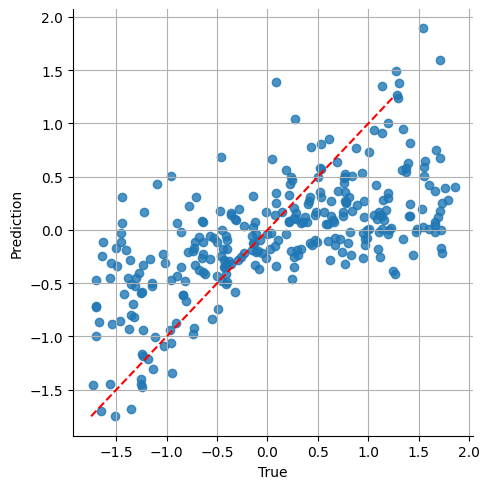

In [131]:
plot_model_results(Y_array_test.flatten(), y_preds.flatten(), title='Ansemble')

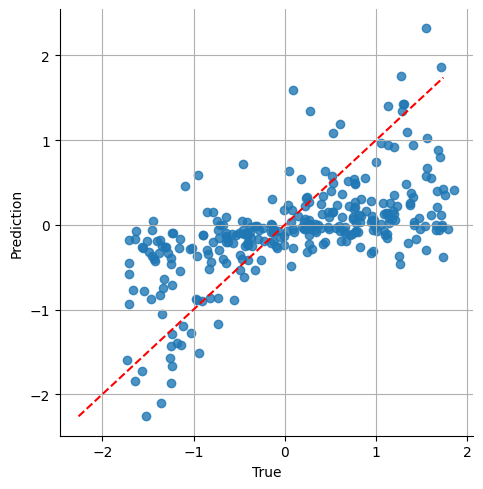

In [136]:
plot_model_results(Y_array_test.flatten(), Y_test_prediction.flatten(), title='Linear Regression')

Экспертное мнение: Сравнивая графики и полученные значения RMSE, можно сделать вывод об удобстве применения гиперпараметров для обучения моделей. Несмотря на то, что модель с ансамблированием является более сложной, наилучшего результата удалось добиться при помощи простой линейной регрессии.